In [1]:
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
def custom_resize(img_path,target_length=16):
    leaf_img = cv2.imread(img_path)
    leaf_img_width = leaf_img.shape[1]
    leaf_img_height = leaf_img.shape[0]
    #target_length = 16
    img_target = np.zeros((target_length, target_length,3), np.uint8)
    if leaf_img_width >= leaf_img_height:
        scale_img_width = target_length
        scale_img_height = int( (float(scale_img_width)/leaf_img_width)*leaf_img_height )
        img_scaled = cv2.resize(leaf_img, (scale_img_width, scale_img_height), interpolation = cv2.INTER_AREA)
        copy_location = int((target_length-scale_img_height)/2)
        img_target[copy_location:copy_location+scale_img_height,:] = img_scaled
    else:
        # leaf_img_width < leaf_img_height:
        scale_img_height = target_length
        scale_img_width = int( (float(scale_img_height)/leaf_img_height)*leaf_img_width )
        img_scaled = cv2.resize(leaf_img, (scale_img_width, scale_img_height), interpolation = cv2.INTER_AREA)
        copy_location = int((target_length-scale_img_width)/2)
        img_target[:, copy_location:copy_location+scale_img_width] = img_scaled 

    return img_target


In [4]:
import os
class CustomDataset(Dataset):
    def __init__(self):
        self.imgs_path = r"D:/CV_Project/Image_with_Context/"
        file_list = []
        for root, dirs, files in os.walk(self.imgs_path):
            for file in dirs:
                file_list.append(os.path.join(root,file))
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for root, dirs, files  in os.walk(class_path):
                #print(root, dirs, files)
                for file in files:
                    if 'context' not in file:
                        context=file.split('.')[0]+'_context.jpg'
                        self.data.append([os.path.join(root+'/', file), os.path.join(root+'/', context), class_name])
        self.class_map = {"class0" : 0, "class1": 1}
        self.img_dim = (15, 15, 0)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        
        
        img_path, context_path, class_name = self.data[idx]
        img = custom_resize(img_path, target_length=16)
        #img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        context_tensor = cv2.imread(context_path)
        context_tensor = torch.from_numpy(context_tensor)
        context_tensor = context_tensor.permute(2, 0, 1)
        
        class_id = torch.tensor([class_id])
        return img_tensor, context_tensor,  class_id

In [7]:
dataset = CustomDataset()
#data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

['D:/CV_Project/Image_with_Context/class0', 'D:/CV_Project/Image_with_Context/class1']


In [8]:

import numpy as np

def split_index(n, val_pct):
    n_val = int(n*val_pct)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [9]:
dataset.__len__()

2211

In [10]:
train_indices, val_indices = split_index(dataset.__len__(), val_pct = 0.3)

In [11]:
from torch.utils.data.sampler import SubsetRandomSampler

In [12]:
batch_size = 10

train_samples = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size, train_samples)

val_samples = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, val_samples)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, context, labels = dataiter.next()

In [14]:
context[0]

tensor([[[ 0,  0,  1,  ...,  0,  0,  0],
         [ 1,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  2,  1,  ...,  3,  3,  0],
         [ 0,  0,  0,  ...,  1,  2,  4],
         [ 1,  1,  0,  ...,  4,  4,  3]],

        [[ 9,  9, 11,  ..., 10, 12, 13],
         [11,  9,  9,  ..., 11, 12, 13],
         [ 9,  9, 10,  ..., 13, 12, 12],
         ...,
         [11, 13, 14,  ..., 26, 26, 23],
         [11, 11, 11,  ..., 21, 22, 24],
         [12, 12, 12,  ..., 24, 24, 23]],

        [[ 3,  3,  5,  ...,  4,  6,  7],
         [ 5,  3,  3,  ...,  5,  6,  7],
         [ 3,  3,  4,  ...,  5,  6,  6],
         ...,
         [ 3,  5,  6,  ..., 12, 12,  9],
         [ 3,  3,  3,  ...,  8,  9, 11],
         [ 4,  4,  4,  ..., 11, 11, 10]]], dtype=torch.uint8)

In [15]:
images, context, labels = images.numpy(), context.cpu().numpy(), labels.numpy()

In [16]:
type(images[0])

numpy.ndarray

In [17]:
images[0]

array([[[ 0,  3,  1,  0,  0,  0,  0,  1,  1,  4,  5,  4,  1,  0,  0,  0],
        [ 0,  3,  1,  0,  0,  0,  0,  2,  2,  4,  4,  2,  0,  0,  0,  0],
        [ 0,  1,  1,  0,  0,  0,  0,  2,  1,  3,  3,  2,  0,  0,  0,  0],
        [ 0,  0,  1,  0,  0,  1,  0,  2,  0,  1,  1,  1,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  1,  2,  1,  3,  0,  0,  0,  0,  0,  1,  0,  0],
        [ 0,  0,  1,  0,  1,  2,  1,  4,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  1,  0,  0,  0,  0,  3,  0,  2,  2,  1,  0,  1,  0,  0],
        [ 0,  0,  1,  0,  0,  0,  0,  1,  1,  2,  2,  2,  1,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  2,  1,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  1,  2,  0,  0,  0,  0],
        [ 0,  0,  1,  2,  2,  1,  3,  0,  2,  1,  1,  1,  0,  0,  0,  0],
        [ 0,  0,  1,  2,  1,  1,  3,  0,  1,  0,  0,  0,  1,  1,  0,  0],
        [ 0,  1,  0,  1,  1,  1,  3,  0,  0,  0,  0,  0,  0,  1,  0,  0],
        [ 0,  1,  0,  0,  1,  1,  2,  

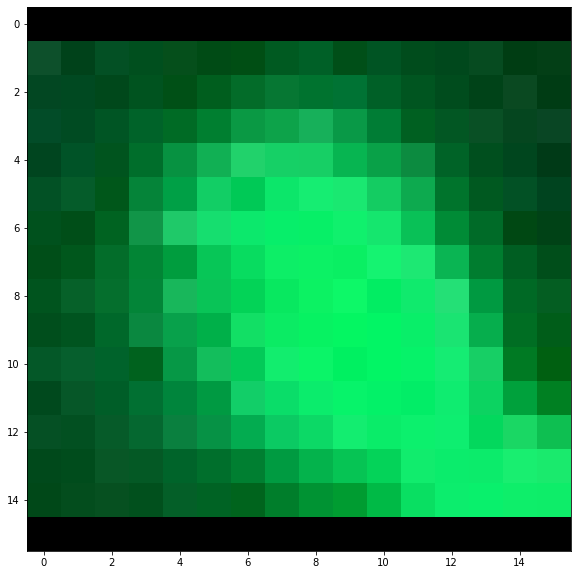

In [20]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(images[1] , (1, 2, 0)))
plt.show()

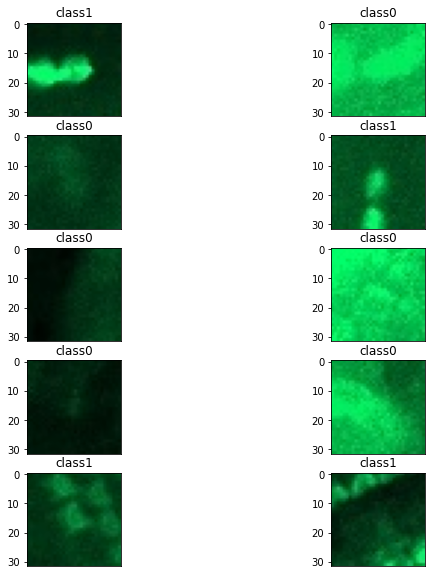

In [23]:
import numpy as np
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, context, labels = dataiter.next()


images, context, labels = images.numpy(), context.cpu().numpy(), labels.numpy()

fig = plt.figure(figsize=(10, 10))
columns = 2
rows = 5
map_classes = {0:"class0" , 1:"class1" }
for i in range(1, columns*rows+1 ):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.transpose(context[i-1] , (1, 2, 0)))
    plt.gca().set_title(map_classes[int(labels[i-1])])
    plt.xticks([])

plt.show()

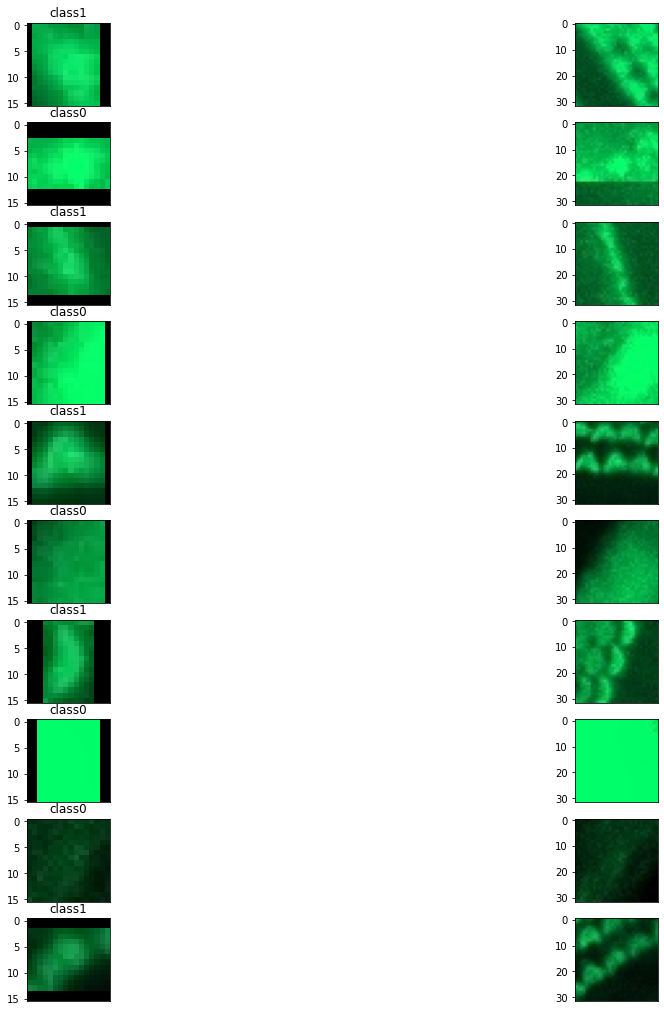

In [41]:
import numpy as np
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, context, labels = dataiter.next()


images, context, labels = images.numpy(), context.numpy(), labels.numpy()

fig = plt.figure(figsize=(18, 18))
columns = 2
rows = 10
map_classes = {0:"class0" , 1:"class1" }
for i in range(0, columns*rows, 2 ):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(np.transpose(images[int(i/2)] , (1, 2, 0)))
    plt.gca().set_title(map_classes[int(labels[int(i/2)])])
    plt.xticks([])
    fig.add_subplot(rows, columns, i+2)
    plt.imshow(np.transpose(context[int(i/2)] , (1, 2, 0)))
    plt.xticks([])
plt.show()

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [46]:
device

device(type='cuda', index=0)

-Resnet: https://www.pluralsight.com/guides/introduction-to-resnet

In [47]:
import torchvision.models as models
net1 = models.resnet18(pretrained=True)
num_ftrs = net1.fc.in_features
net1.fc = nn.Linear(num_ftrs, 2)
net1 = net1.cuda() if device else net1
net1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
net2 = models.resnet18(pretrained=True)
num_ftrs = net2.fc.in_features
net2.fc = nn.Linear(num_ftrs, 2)
net2 = net2.cuda() if device else net2
net2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
dataiter = iter(train_loader)
images, context, labels = dataiter.next()
image = images[0]
image = image[None, :, : , :]
#print(images)
image = image.type(torch.FloatTensor)
#image = a[:, :, None, :]
net1 = models.resnet18(pretrained=True)
fe = list(list(net1.children())[:-1])

In [5]:
dataiter = iter(train_loader)
images, context, labels = dataiter.next()
image = images[0]
image = image[None, :, : , :]
#print(images)
image = image.type(torch.FloatTensor)
#image = a[:, :, None, :]
net1 = models.resnet18(pretrained=True)
fe = list(list(net1.children())[:-1])
for index, i in enumerate(fe):
    image = i(image)
    print(index, image.size())

In [136]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()


In [137]:
n_epochs = 30
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        data_ = data_.float()
        target_ = torch.squeeze(target_)
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (val_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            data_t = data_t.float()
            target_t = torch.squeeze(target_t)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(val_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/30], Step [0/222], Loss: 0.8840
Epoch [1/30], Step [20/222], Loss: 0.6540
Epoch [1/30], Step [40/222], Loss: 0.3876
Epoch [1/30], Step [60/222], Loss: 0.6895
Epoch [1/30], Step [80/222], Loss: 0.3999
Epoch [1/30], Step [100/222], Loss: 0.5027
Epoch [1/30], Step [120/222], Loss: 0.5077
Epoch [1/30], Step [140/222], Loss: 0.5060
Epoch [1/30], Step [160/222], Loss: 0.8607
Epoch [1/30], Step [180/222], Loss: 0.7114
Epoch [1/30], Step [200/222], Loss: 0.3865
Epoch [1/30], Step [220/222], Loss: 0.5694

train-loss: 0.5536, train-acc: 72.5712
validation loss: 0.4304, validation acc: 79.8464

Improvement-Detected, save-model
Epoch 2

Epoch [2/30], Step [0/222], Loss: 0.3052
Epoch [2/30], Step [20/222], Loss: 0.3315
Epoch [2/30], Step [40/222], Loss: 0.3800
Epoch [2/30], Step [60/222], Loss: 0.4528
Epoch [2/30], Step [80/222], Loss: 0.3230
Epoch [2/30], Step [100/222], Loss: 0.4648
Epoch [2/30], Step [120/222], Loss: 0.5827
Epoch [2/30], Step [140/222], Loss: 0.6909
Epoch [2/30

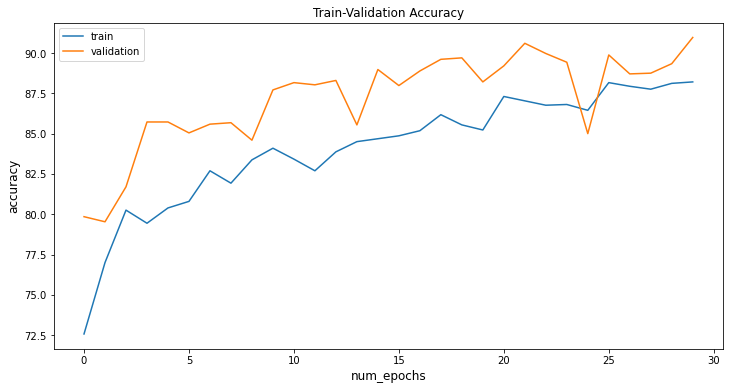

In [142]:
fig = plt.figure(figsize=(12,6))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

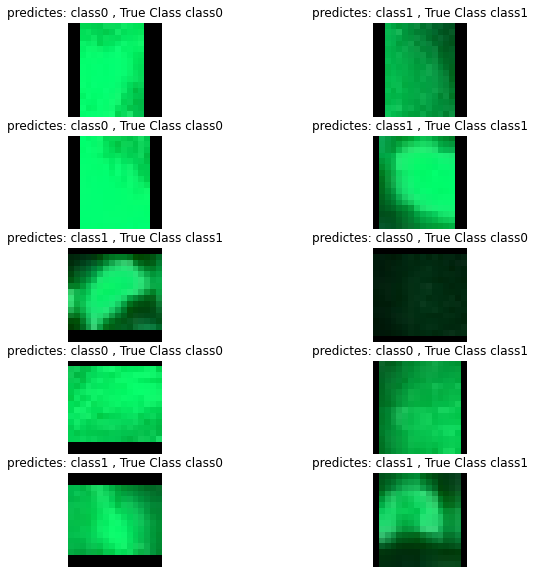

In [152]:
def visualize_model(net, num_images=10):
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))
    
    for i, data in enumerate(val_loader):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        #print(labels)
        outputs = net(inputs.float())
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() #if use_cuda else preds.numpy()
        labels = labels.cpu().numpy()
        #print(labels)
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2 , images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {} , True Class {}'.format(map_classes[preds[j]], map_classes[labels[j][0]]))
            #plt.imshow(inputs[j])
            plt.imshow(np.transpose(inputs[j].cpu().numpy() , (1, 2, 0)))
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()

- Transfer Learning Using Resnet: https://www.pluralsight.com/guides/introduction-to-resnet
- 1D target tensor expected : https://python.tutorialink.com/pytorch-1d-target-tensor-expected-multi-target-not-supported/
- Flowers Recognition: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition/code?datasetId=8782&sortBy=voteCount
- Facial Landmark dataset: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- Dogs VS Cats Dataset: https://www.kaggle.com/competitions/dogs-vs-cats/code?competitionId=3362&sortBy=voteCount
    - https://www.kaggle.com/code/jaeboklee/pytorch-cat-vs-dog
    - https://medium.com/analytics-vidhya/implementing-cnn-in-pytorch-with-custom-dataset-and-transfer-learning-1864daac14cc
Handle images with different sizes: https://www.tensorflow.org/api_docs/python/tf/image
        - https://stackoverflow.com/questions/41907598/how-to-format-the-image-data-for-training-prediction-when-images-are-different-i
        - https://wandb.ai/ayush-thakur/dl-question-bank/reports/How-to-Handle-Images-of-Different-Sizes-in-a-Convolutional-Neural-Network--VmlldzoyMDk3NzQ
        - Custom Resize function : https://datascience.stackexchange.com/questions/61671/dealing-with-input-images-of-different-shapes-in-pytorch